In [1]:
from micrograd.vector import Tensor, MLP
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch

### Unit Test for MSS

In [2]:
n = 10
x = np.random.rand(n, 1)

t = Tensor(x)
mss = t.mss()
mss.grad = 1.0
mss._backward()

In [3]:
tr = torch.Tensor(x)
tr.requires_grad = True
mss_tr = torch.mean(torch.pow(tr, 2))
mss_tr.backward()

In [4]:
print('MSS %.4f, MSS_Tr %.4f' % (mss.data, mss_tr))
print('Difference in Grad %.4f' %
      np.linalg.norm(t.grad - tr.grad.numpy()))

MSS 0.2634, MSS_Tr 0.2634
Difference in Grad 0.0000


### Unit Test for __matmul__

In [5]:
n = 2
m = 10
x = np.random.rand(n, 1)
W = np.random.rand(m, n)

x_t = Tensor(x)
W_t = Tensor(W)
mss = (W_t @ x_t).mss()
mss.backward()

In [6]:
x_tr = torch.Tensor(x)
x_tr.requires_grad = True

W_tr = torch.Tensor(W)
W_tr.requires_grad = True

mss_tr = torch.mean(torch.pow(W_tr @ x_tr, 2))
mss_tr.backward()

In [7]:
print('MSS %.4f, MSS_Tr %.4f' % (mss.data, mss_tr))
print('Difference in Grad for x: %.4f' %
      np.linalg.norm(x_t.grad - x_tr.grad.numpy()))
print('Difference in Grad for W: %.4f' %
      np.linalg.norm(W_t.grad - W_tr.grad.numpy()))

MSS 0.1808, MSS_Tr 0.1808
Difference in Grad for x: 0.0000
Difference in Grad for W: 0.0000


### Build a simple MLP for binary classification

init model

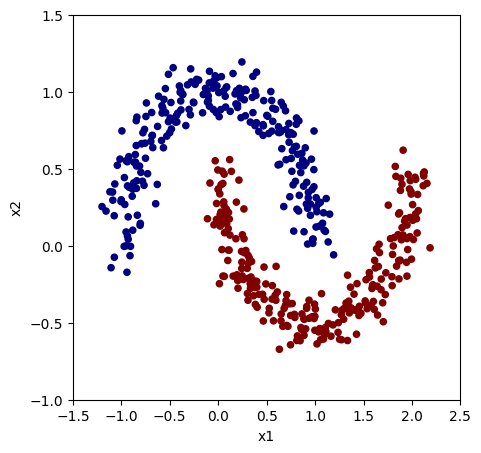

In [8]:
n_samples = 500
X, y = make_moons(n_samples=n_samples, noise=0.1)

y = y*2 - 1 # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

In [9]:
# initialize model
model = MLP(n_in=2, n_hidden=10, n_out=1)

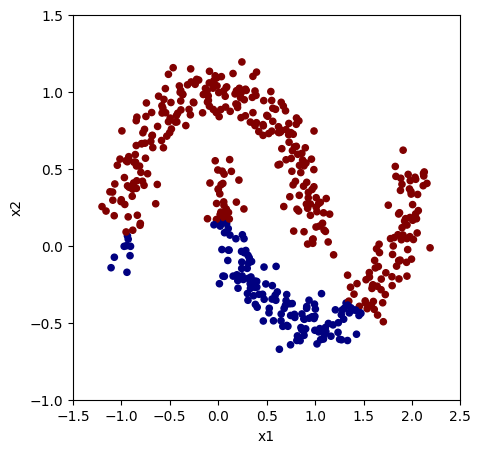

In [10]:
y_pred = model.predict(X)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y_pred, s=20, cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

training

In [11]:
margin = Tensor(np.array([1.0]).reshape(1, 1))
factor = Tensor(1 / np.array([n_samples]).reshape(1, 1))

In [12]:
n_epochs = 501
epoch_loss = []

for epoch in range(n_epochs):
    model.zero_grad()
    total_loss = 0.0

    # run through data
    for idx in range(X.shape[0]):
        x = Tensor(X[idx].reshape(2, 1))
        y_t = Tensor(-np.array([y[idx]]).reshape(1, 1))
        y_p = model.forward(x)

        loss = (margin + y_t * y_p).relu() * factor
        loss.backward()

        total_loss += loss.data

    lr = 0.1
    for p in model.params:
        p.data -= lr * p.grad

    epoch_loss.append(total_loss[0, 0])

    if epoch % 50 == 0:
        print('Epoch %d, Loss %.4f' % (epoch, total_loss[0, 0]))

Epoch 0, Loss 2.9737


Epoch 50, Loss 0.0270
Epoch 100, Loss 0.0085
Epoch 150, Loss 0.0046
Epoch 200, Loss 0.0028
Epoch 250, Loss 0.0024
Epoch 300, Loss 0.0019
Epoch 350, Loss 0.0015
Epoch 400, Loss 0.0013
Epoch 450, Loss 0.0012
Epoch 500, Loss 0.0011


In [13]:
# after training
y_pred = model.predict(X)


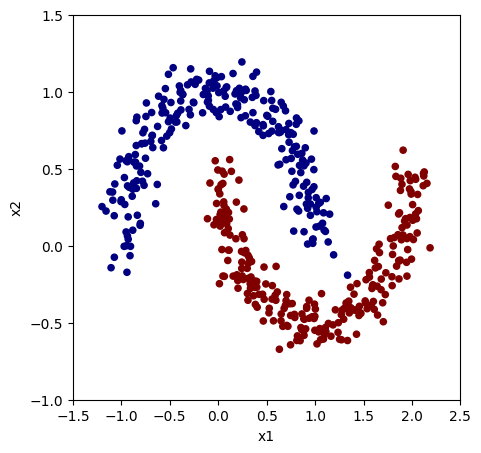

In [14]:
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y_pred, s=20, cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()

Decision Boundary

In [15]:
# visualize decision boundary

h = 0.025
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

scores = model.predict(Xmesh)
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

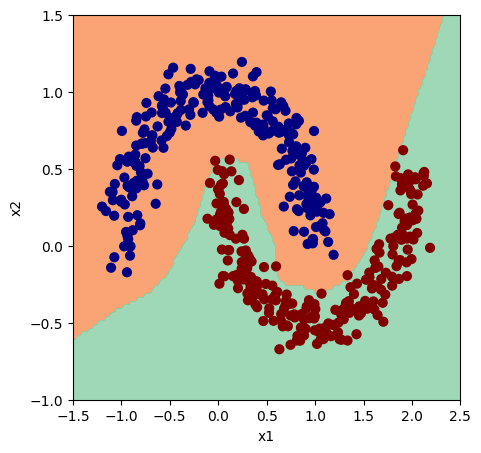

In [16]:
fig = plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='jet')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()